# Multilingual Entity Linking in ParlaMint

This notebook contains all the code used in the epxeriments in the Workshop paper "Entity Linking in the ParlaMint corpus". Although the language files were too big to be included on GitHub, they are available through Surfdrive on request.

The notebook contains both a small comparison between the systems as well as the implementations of the methods used to retrieve results from the 3 API's respectively. The notebook shows the experiments conducted in the order in which they are discussed in the paper.

## Index
1. [Spelling errors in ParlaMint](#spelling_errors)
2. [Setting up the systems](#system_setup)
   - 2.1 [DBPedia](#dbpedia_setup)
   - 2.2 [WikiData](#wikidata_setup)
   - 2.3 [YAGO](#yago_setup)
3. [Comparison on Local Politicians](#experiment_1)
4. [Lemmatization]
5. [Aliasing]


# Systems

All the three systems used in this research can be are available online, and they can either be downloaded entirely, or be used through an API. below are the websites for all three systems. All three systems can work with multiple languages, although the language support is not the same for all three systems.

- https://www.dbpedia-spotlight.org
- https://yago-knowledge.org
- https://www.wikidata.org/wiki/Wikidata:Main_Page

In [1]:
# Imports
# imports
import re
import os
import json
import random
import requests
import numpy as np
import pandas as pd
from typing import List, Dict, Union
from tqdm import tqdm
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

In [2]:
# Inladen data
# Loading of datasets and construction of corpora
# dataset loading
data_dir = '../Projects/ParlaMintLREpaper/data_with_lemma'

all_csv_files = os.listdir(data_dir)
if '.DS_Store' in all_csv_files:
    all_csv_files.remove('.DS_Store')

# Nu gaan we de dataframes aan elkaar plakken, zodat we er weer makkelijk mee kunnen werken.
combined_df = pd.concat([pd.read_csv(os.path.join(data_dir, country_file), quotechar='|', infer_datetime_format=True) for country_file in all_csv_files])



Below is a small table with the languages that are officialy supported by the three systems.

| Language | DBPedia| WikiData | YAGO |
| --- | --- | --- | --- |
| English | $\checkmark$ | $\checkmark$ | $\checkmark$ |
| Dutch | $\checkmark$ | $\checkmark$ |  $\checkmark$ |
| French| $\checkmark$ | $\checkmark$ | $\checkmark$ |
| Polish | $\times$ | $\checkmark$ | $\checkmark$ |
| Czech | $\times$ | $\checkmark$ | $\checkmark$ |
| Hungarian | $\checkmark$ | $\checkmark$ | $?$ |
| Italian | $\checkmark$ | $\checkmark$ | $\checkmark$ |
| Spanish | $\checkmark$ | $\checkmark$ | $\checkmark$ |
| Icelandic | $\times$ | $\checkmark$ | $\checkmark$ |
| Danish | $\times$ | $\checkmark$ | $\checkmark$ |
| Croatian | $\times$ | $\checkmark$ | $\checkmark$ |
| Latvian| $\times$ | $\checkmark$ | $\checkmark$ |
| Lithuanian | $\times$ | $\checkmark$ | $\checkmark$ |
| Turkish| $\checkmark$ | $\checkmark$ | $\checkmark$ |

<a id='spelling_errors'></a>

## Experiment 0: Detecting spelling mistakes in the ParlaMint Entities

Although spelling mistakes are quite rare in the ParlaMint subdatasets because of the careful curation of the parliamentary proceedings, spelling mistakes do show up in rare occassions. To get some statistics on the amount of spelling mistakes happening, we calculated string similarities between the PERS entities in a country and checked for high similarity of an entity that occurred often with an entity that was very similar that did not occur often. We then manually check if they are actually mistakes. For the similarity measure we use the cosine similarity with TF-IDF character ngrams, as it is a simple and fast distance measure. This serves simply as a tool to extract some examples of spelling mistakes

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
dutch_df = combined_df[combined_df.lang == 'NL']
dutch_persons = dutch_df[dutch_df.type == 'PER']

In [5]:
unique_persons = dutch_persons.string.str.lower().unique().tolist()

In [6]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))

In [7]:
person_vectors = vectorizer.fit_transform(unique_persons)
person_similarities = (person_vectors @ person_vectors.T).todense() # as these vectors are L2 normalized, cosine similarity is now equal to taking the dot product
# we don't want to end up with just the entity itself as most similart, so we set the diagonal to 0.
np.fill_diagonal(person_similarities, 0)

In [8]:
most_similar_names = person_similarities.argmax(axis=1)

In [9]:
most_similar_pairs = {unique_persons[i]: unique_persons[most_similar_names[i].item(0)] for i in range(len(unique_persons))}

In [10]:
# oettinger - ottinger
# pechtold - pechtol
# segers - seger
# eijsink - leijsink
# rutte - ruttem

In [11]:
person_occurrences = dutch_persons['string'].str.lower().value_counts()

<a id='system_setup'></a>

# Setting up the EL systems

In this part of the code, DBPedia, WikiData and YAGO are set up so that they can work through python code. To make the implementation more clean, a base class is set up, from which all of the systems inherit, as they share much of the same underlying structure.

In [23]:
from abc import ABC, abstractmethod

In [24]:
class QueryKnowledgeBase(ABC):
    """
    This class defines a generic way of quering a querying a knowledge base..
    
    """
    def __init__(self):
        pass
    
    @abstractmethod
    def build_query(self):
        pass
    
    def batch_queries(self, sleep_time: float):
        """
        :param: sleep_time: (float) This parameter is a float representing the
        interval between consecutive queries in seconds.
        """
    @abstractmethod
    def resolve_entity(self):
        pass
    
    def send_query(self, api_url, params=None):

        api_response = requests.post(api_url, headers={'accept': 'application/json'}, params=params)
        return api_response.json()
        
    @abstractmethod
    def return_results(self, detailed: bool = False):
        pass

<a id='dbpedia_setup'></a>

## DBPedia

In [25]:
class QueryDBPedia(QueryKnowledgeBase):
    """
    Because of several limitations of DBPedia (discussed in detail below) a multi-step resolution process is used
    to obtain the best possible performance of the system.

    1. Entity Recognition
        1.1 Send a query to the entity recogntion system, together with the language of the entity.

        1.2 If this query does not return an entity, we will use the 'search' functionality of 
        DBPedia, which can be used to search entities. However, this functionality is only implemented
        for English, and can produce wildly inaccurate predictions for other languages. For this reason
        we check whether the original entity is contained in the output.

        1.3 If both methods fail to produce an entity, we revert to the entity with spaces replaced
        by underscores, the default format of DBPedia resources. 'Mark Rutte' -> 'Mark Rutte'

    2. Entity Retrieval
        2.1 The entity name retrieved from step 1 is used to retrieve entity information from the DBPedia
        knowledge base. Because not all languages are supported in DBPedia in some languages seem to be broken
        ('italy' for example), the entity is first searched in the English version.

        2.2 If this does not work, the method back off to the native language of the entities and retries.


    3. ID Retrieval
        3.1 In order to link entities to a knowledge base, we retrieve the Q-items present in the WikiData system.
        These items are sometimes also linked in DBPedia. If these exist, we will retrieve those.
        3.2 If these do not esit, we attempt to retrieve a wikipeida article link, and use an wikiata API call
        to retrieve the corresponding Q-Item
    """
        
    def __init__(self):
        super().__init__()
        self.id = "DBPEDIA"
        
    def entity_recognition(self, entity: str, lang: str) -> str:
        # this list doesnt contain all languages supported in the demo, as some of these dont work in the API
        if lang not in ['ca', 'de', 'fr', 'hu', 'nl', 'ro']:
            # try live, and see if this works
            lang = 'en' # default to english
            dbpedia_sparql_endpoint = 'http://dbpedia.org/sparql/'

        else:
            dbpedia_sparql_endpoint = 'http://%s.dbpedia.org/sparql/' % lang


        dbpedia_search_endpoint = 'https://lookup.dbpedia.org/api/search'

        # First do a search for the entity if this doesnt work we go ahead and use english search
        search_params = {
            'query': entity,
            'format': 'json'
        }
        
        entity_recognition_params = {
            'text': entity
        }


        dbpedia_query_url = 'https://api.dbpedia-spotlight.org/%s/candidates' % lang
        response = requests.post(dbpedia_query_url, headers={'accept': 'application/json',
                                                            'confidence': str(confidence)}, data=params).json()        

        if type(response['annotation'].get('surfaceForm')) == list and (type(response['annotation'].get('surfaceForm'))):
            uri_label = response['annotation']['surfaceForm'][0]['resource']['@uri']

        elif response['annotation'].get('surfaceForm', None):
            uri_label = response['annotation']['surfaceForm']['resource']['@uri']

        if (not response['annotation'].get('surfaceForm', None)) or (uri_label != entity.replace(' ', '_')):
            search_response = requests.post(dbpedia_search_endpoint, headers={'accept': 'application/json'}, data=s_params).json()
            if search_response['docs']:
                uri_label = search_response['docs'][0]['resource'][0].split('/')[-1]
                if use_raw_entity:
                    if uri_label != entity.replace(' ', '_'):
                        uri_label = entity.replace(' ', '_')
            else:
                if use_raw_entity:
                    uri_label = entity.replace(' ', '_')
                else:
                    return None


        
        
        
    def build_query(self):
        pass
        
    def return_results(self):
        pass
    
    def resolve_entity(self):
        pass
    

In [26]:
# Het opzetten van de drie systemen
# dbpedia

def get_dbpedia_result(entity, lang, return_string=False, confidence=0.50, use_raw_entity=False):
    # This is the match in dbpedia we will have to use a SPARQL query next to fetch the wikidata Q ID
    # I include english itslef here as well to make sure we don't add 'en' to urls because that doenst work well
    if lang not in ['ca', 'de', 'fr', 'hu', 'nl', 'ro']:
        lang = 'en' # default to english
        dbpedia_sparql_endpoint = 'http://dbpedia.org/sparql/'

    else:
        dbpedia_sparql_endpoint = 'http://%s.dbpedia.org/sparql/' % lang
            
    
    dbpedia_search_endpoint = 'https://lookup.dbpedia.org/api/search'
    
    entity_research_links = {item: "NULL" for item in entity}

    # First we try candidates, because this one is more conservative and will not usally get false positive
    
    # First we have to prep our entities to work with the candidates API
    entity_string_list = " ".join(entity)
    
    params = {'text': entity_string_list}
    dbpedia_query_url = 'https://api.dbpedia-spotlight.org/%s/candidates' % lang
    response = requests.post(dbpedia_query_url, headers={'accept': 'application/json',
                                                        'confidence': str(confidence)}, data=params).json()['annotation']['surfaceForm']       
    

    for found_entity in response:
        found_name = found_entity['resource']['@label']
        found_uri = found_entity['resource']['@uri']
        if entity_research_links.get(found_name, None):
            entity_research_links[found_name] = found_uri

    # get the people who'se names have not yet been resolved
    unresolved_entity_names = [key for key, value in entity_research_links.items() if value == "NULL"]

    for entity in tqdm(unresolved_entity_names):
        search_params = {'query': entity, 'format': 'json'}
        search_result = requests.post(dbpedia_search_endpoint, headers={'accept': 'application/json'}, data=search_params).json()['docs']
        if search_result:
            search_name = search_result[0]['resource'][0].split('/')[-1]
            entity_research_links[entity] = search_name
    
    unresolved_entity_names_2 = [key for key, value in entity_research_links.items() if value == "NULL"]
    
    for item in unresolved_entity_names_2:
        entity_research_links[item] = item.replace(" ", '_')
    
    # To get the best results we have to de multiple retrieval attempts, we will first try to get the
    # entity from the main dbpedia database, as this gives us the most information, if this is not 
    # possible, we will go to a language specific version.
    
    sparql_query_1 = """
    SELECT distinct ?wikidata_concept
    WHERE {<http://dbpedia.org/resource/%s> owl:sameAs ?wikidata_concept .
    FILTER(REGEX(STR(?wikidata_concept), "Q([0-9]+)"))
    }
    LIMIT 1
    """
    main_dbpedia_response = requests.get('http://dbpedia.org/sparql/',
                                            params = {'format': 'json',
                                                      'query': sparql_query_1 % uri_label}).json()
    
    if main_dbpedia_response['results']['bindings']:
        q_number = main_dbpedia_response['results']['bindings'][0]['wikidata_concept']['value'].split('/')[-1]
    else:
        # Back off to the local entity and find the Q number or wikilink here
        sparql_query_2 = """
        PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
        SELECT distinct ?wikidata_concept ?wikipage ?q_number
        WHERE { ?wikidata_concept foaf:name "%s"@%s .
            OPTIONAL {?wikidata_concept foaf:isPrimaryTopicOf ?wikipage}
            OPTIONAL {?wikidata_concept owl:sameAs ?q_number
            FILTER(REGEX(STR(?q_number), "Q([0-9]+)", "s"))
            }
        }
        LIMIT 1
        """
        wikilink_response = requests.get(dbpedia_sparql_endpoint,
                                                params = {'format': 'json',
                                                          'query': sparql_query_2 % (uri_label.replace('_', ' '), lang)}).json()
        if wikilink_response['results']['bindings']:
            if not wikilink_response['results']['bindings'][0].get('wikipage', None):
                return None
            wikipage = wikilink_response['results']['bindings'][0]['wikipage']['value']
            find_q_item_params = {
            'action': 'query',
            'prop': 'pageprops',
            'ppprop': 'wikibase_item',
            'redirects': 1,
            'format': 'json',
            'titles': wikipage.split('/')[-1]}
            lang_wiki = wikipage.split('http://')[1][:2]

            q_params_url = 'https://%s.wikipedia.org/w/api.php' % lang_wiki

            new_q_number = requests.post(q_params_url, params=find_q_item_params, headers={'Content-Type': 'application/json'}).json()
            q_number = list(new_q_number['query']['pages'].values())[0]['pageprops']['wikibase_item']
        else:
            return None
        
    if not return_string:
        return q_number
    else:
        return (uri_label, q_number) 


<a id='wikidata_setup'></a>

## WikiData

In [32]:
class QueryWikiData(QueryKnowledgeBase):
    """
    This class supports batch querying, which is significantly faster than issuing
    multiple queries seperately, when retrieving multiple entities.
    
    """
    
    def __init__(self):
        super().__init__()
        self.api_endpoint = 'https://query.wikidata.org/sparql'
        self.id = "WIKIDATA"
        
    def instantiate_sparql_query(self, entity: str, lang: str) -> str:
        """
        :param: entity (str): string specifying the entity that is searched for. 
        :param: lang (str): Language in which the entity is searched for.
        
        """
        
        sparql_query = """        SELECT * WHERE {
          VALUES ?searchTerm { %s }
          SERVICE wikibase:mwapi {
              bd:serviceParam wikibase:endpoint "www.wikidata.org";
                              wikibase:api "EntitySearch";
                              wikibase:limit "once" ;
                              mwapi:search ?searchTerm;
                                mwapi:limit 1;
                              mwapi:language "%s".
              ?item wikibase:apiOutputItem mwapi:item.
              ?num wikibase:apiOrdinal true.
          }
        }
        """ % (entity, lang)
        
        return sparql_query

   

    def build_query(self, entity: Union[str, List], lang: str):
        """
        :param: entity (str): string specifying the entity that is searched for. 
        :param: lang (str): Language in which the entity is searched for.
        
        """
        # support both single entity retrieval and batch entity retrieval
        if type(entity) == str:
            entity = [entity]
        
        string_entities = " ".join(['"%s"' % item for item in entity])
        query_params = {'format': 'json', 'query': self.instantiate_sparql_query(string_entities, lang)}
        return query_params
    
    
    def return_results(self, result_json: dict, input_queries: str) -> List[Dict]:
        """
        :param: result_json (dict): dictionary containing the API response
        from WikiData. The result is in the form {'vars': [], 'results':{'bindings': []}}
        :param: input_queries (str): Because WikiData does not return anything when an entity is not
        retrieved, we need the input query to find whether something was returned for that specific search term.
        """
        
        results = []
        
        # check wheter we got a response
        if not result_json['results']['bindings']:
            return None
        
        returned_items = result_json['results']['bindings']
        filtered_results = {result['searchTerm']['value']: result['item']['value'].split('/')[-1] for result in returned_items}
        
        output = [filtered_results.get(query, "NIL") for query in input_queries]
        
        assert len(output) == len(input_queries)
        
        return output
        
    
    def resolve_entity(self, entity: Union[str, List], lang: str) -> List[Dict]:
        """
        :param: entity (str): string specifying the entity that is searched for. 
        :param: lang (str): Language in which the entity is searched for.
        
        """
        sparql_query = self.build_query(entity, lang)
        query_results_json = self.send_query(self.api_endpoint, params=sparql_query)
        formatted_response = self.return_results(query_results_json, entity)
        return formatted_response
    
        

In [33]:
wikidata_resolver = QueryWikiData()

In [34]:
ent = wikidata_resolver.resolve_entity(['Europa', 'ff', 'sdfsdf'], 'bg')

In [35]:
ent

['Q3143', 'Q184172', 'NIL']

<a id='yago_setup'></a>

## YAGO

In [36]:
class QueryYAGO(QueryKnowledgeBase):
    """
    This class supports batch querying, which is significantly faster than issuing
    multiple queries seperately, when retrieving multiple entities.
    
    """
    
    def __init__(self):
        super().__init__()
        self.api_endpoint = 'https://yago-knowledge.org/sparql/query'
        self.id = "YAGO"
        
    def instantiate_sparql_query(self, entity: str, number_of_queries: int) -> str:
        """
        :param: entity (str): string specifying the entity that is searched for. 
        :param: number_of_queries (str): Number of queries, used to retrieve the Q numbers
        
        """
        
        sparql_query = """
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        select  *
        where {
              values ?item { %s } 
              ?resource rdfs:label ?item .
              ?resource owl:sameAs ?q_number
            filter(regex(STR(?q_number), "Q[0-9].+", "s" )) 
            }  
        LIMIT %d
        """ % (entity, number_of_queries)
        
        return sparql_query

   

    def build_query(self, entity: Union[str, List], lang: str):
        """
        :param: entity (str): string specifying the entity that is searched for. 
        :param: lang (str): Language in which the entity is searched for.
        
        """
        # support both single entity retrieval and batch entity retrieval
        if type(entity) == str:
            entity = [entity]
        
        string_entities = " ".join(['"%s"@%s' % (item, lang) for item in entity])
        query_params = {'format': 'json', 'query': self.instantiate_sparql_query(string_entities, len(entity))}
        return query_params
    
    
    def return_results(self, result_json: dict, input_queries: str) -> List[Dict]:
        """
        :param: result_json (dict): dictionary containing the API response
        from WikiData. The result is in the form {'vars': [], 'results':{'bindings': []}}
        :param: input_queries (str): Because WikiData does not return anything when an entity is not
        retrieved, we need the input query to find whether something was returned for that specific search term.
        """
        
        results = []
        
        # check wheter we got a response
        if not result_json['results']['bindings']:
            return None
        
        returned_items = result_json['results']['bindings']
        filtered_results = {result['item']['value']: result['q_number']['value'].split('/')[-1] for result in returned_items}
        
        output = [filtered_results.get(query, "NIL") for query in input_queries]
        
        assert len(output) == len(input_queries)
        
        return output
        
    
    def resolve_entity(self, entity: Union[str, List], lang: str) -> List[Dict]:
        """
        :param: entity (str): string specifying the entity that is searched for. 
        :param: lang (str): Language in which the entity is searched for.
        
        """
        sparql_query = self.build_query(entity, lang)
        query_results_json = self.send_query(self.api_endpoint, params=sparql_query)
        formatted_response = self.return_results(query_results_json, entity)
        return formatted_response
    
        

In [37]:
# instantiate a yago resolver
yago_resolver = QueryYAGO()


## Experiment Setup

In [42]:
from sklearn.metrics import accuracy_score
class Experiment():
    def __init__(self, systems=["DBPEDIA", "WIKIDATA", "YAGO"], lang='en'):
        systems_dict = {"DBPEDIA": QueryDBPedia(), "WIKIDATA": QueryWikiData(), "YAGO": QueryYAGO()}
        self.used_systems = [systems_dict[system] for system in systems]
        self.lang = lang
        
        # Determine if some language processing must be done
        
    def run_experiment(self, gold_standard_text: List[str]):
        system_predictions = {}
        
        for system in self.used_systems:
            system_out = system.resolve_entity(gold_standard_text, self.lang)
            system_predictions[system.id] = system_out
        return system_predictions

    
    def accuracy(self, pred_dict: Dict, gold_standard_labels: List[str]):
        return {sys_id: accuracy_score(gold_standard_labels, pred_dict[sys_id]) for sys_id in pred_dict.keys()}
        
    def mistake_analysis(self, pred_dict: Dict, gold_standard_labels: List[str]):
        # This method takes the output of the systems, and shows overlap and differences in mistakes
        # add can also show what types of errors the systems made (wrong entities or NIL predictions)
        # The code only works with two or three systems
        
        # First we need to make a dictionairy with the mistakes of all three systems
        # Here we identify a mistake by using the index of the item that it didnt predict correctly.
        
        mistakes = defaultdict(list)
        
        for system, predictions in pred_dict.items():
            for i in range(len(predictions)):
                if predictions[i] != gold_standard_labels[i]:
                    mistakes[system].append(predictions[i])
        

        wikidata = set(mistakes['WIKIDATA'])
        dbpedia = set(mistakes['DBPEDIA'])
        yago = set(mistakes['YAGO'])

        a = len(wikidata - (yago | dbpedia))
        b = len(dbpedia - (wikidata | yago))
        c = len((wikidata & dbpedia) - yago)
        d = len(yago - (wikidata | dbpedia))
        e = len((yago & wikidata) - dbpedia)
        f = len((yago & dbpedia) - wikidata)
        g = len(yago & wikidata & dbpedia)

        return (a, b, c, d, e, f, g), ["WIKIDATA", "DBPEDIA", "YAGO"]
            
            
            
            
            
        

In [43]:
a = Experiment(systems=["YAGO", "WIKIDATA"])

In [44]:
def get_entities_from_parlamint(ent_type, country=None, exclude_types=None):
    assert ent_type in ["international", 'regional', 'local']
    
    filtered_combined_df = combined_df.drop_duplicates(subset=['lang', 'string'])
    
    if exclude_types:
        filtered_combined_df = filtered_combined_df[~filtered_combined_df['type'].isin(exclude_types)]
    
    popularity_df = filtered_combined_df[['string', 'lang', 'lemma']]
    
    popular_ents = popularity_df.groupby('string')['lang'].nunique().to_dict()
    popularity_df['lang_count'] = popularity_df['string'].map(popular_ents)
    
    
    if ent_type == "international":
        return popularity_df[(popularity_df['lang_count'] > 8) & (popularity_df['lang'] == country)]
    elif ent_type == "regional":
        return popularity_df[(( popularity_df['lang_count'] >= 2) & ( popularity_df['lang_count'] <= 4)) & (popularity_df['lang'] == country)]
    else:
        return popularity_df[(popularity_df['lang_count'] == 1) & (popularity_df['lang'] == country)]

# Experiment 1: Popular Entities test

In this test we are first going to look at the international entities, than the regional entities and finally the local entities. For now I have just used the unordered lists within groups, not sorting on total number of occurrences, I can add this in later and see how that changes results.


In [410]:
international_ents_french = get_entities_from_parlamint('international', 'FR')[:20]['lemma'].tolist()

<ipython-input-365-ae4ab4ec3f94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popularity_df['lang_count'] = popularity_df['string'].map(popular_ents)


In [411]:
international_ents_french

['C',
 'Paris',
 'Europe',
 'S',
 'Macron',
 'François Hollande',
 'Emmanuel Macron',
 'Venezuela',
 'Sahel',
 'Iran',
 'Ford',
 'Lyon',
 'D',
 'PISA',
 'Albert',
 'à',
 'Rotterdam',
 'le monde',
 'Chicago',
 'Jersey']

In [412]:
gold_labels_french = ['NIL', 'Q90', 'Q46', 'NIL',
                                    'Q3052772', 'Q157', 'Q3052772',
                                    'Q717', 'Q66065',
                                    'Q794', 'Q44294', 'Q456',
                                    'NIL', 'Q13375', 'NIL',
                                    'NIL', 'Q34370', 'Q12461',
                                    'Q1297', 'Q1408']

In [268]:
for sys in ['DBPEDIA', 'WIKIDATA', 'YAGO']:
    
    acc = accuracy(international_ent_results['gold'],
                   international_ent_results[sys])
    
    print("%s accuracy is %.2f" % (sys, acc))

DBPEDIA accuracy is 0.45
WIKIDATA accuracy is 0.70
YAGO accuracy is 0.55


In [413]:
international_french_experiment = Experiment(systems=["WIKIDATA", "YAGO"], lang='fr')

In [414]:
french_results = international_french_experiment.run_experiment(international_ents_french)

In [416]:
international_french_experiment.accuracy(french_results, gold_labels_french)

{'WIKIDATA': 0.7, 'YAGO': 0.1}

<a id='experiment_1'></a>

# Experiment 1: Local Politicians from Parlamint

In this experiment, we are going to emulate the case of linking names of politicians using the three systems described above. For this we use WikiData to extract members of parliament from countries, using 'MemberOf' relationships.

In [47]:
# The syntax here is taken from the https://www.wikidata.org/wiki/Wikidata:WikiProject_every_politicianhttps://www.wikidata.org/wiki/Wikidata:WikiProject_every_politician
# Project, and copied from some examples of countries that used this query. 
# although it will not work perfectly for all countries, all these politicians have
# wikidata entries (by definition) and therefore can be used as gold standard
# As seen in the query, I filtered on currently active members, although this 
# might not be necessary. 

# TODO: I could also do this for 'ministers' only, this would only require a very small 
# change to the current code, as I would just have to replace 's:P39/wdt:P279*' (occupation)
# with the q code of minister in a specific country.

# Because some data on end dates is missing, the query will sometimes return policiticans 
# that are historical 'start data 1818' but still returned by our query. Although this is not 
# necessarily a problem, I added another filter that binds the start date to a more recent
# date, to limit the number of results.

# I also return in the native language when possible, to ensure a difficult enough linking later
base_sparql_query = """
SELECT ?item ?itemLabel ?group ?groupLabel ?district ?districtLabel ?term ?termLabel ?start ?end
WHERE 
{
  ?item p:P39 ?statement .
  ?statement ps:P39/wdt:P279* wd:%s ; pq:P580 ?start .
  OPTIONAL { ?statement pq:P2937 ?term }
  OPTIONAL { ?statement pq:P582  ?end }
  OPTIONAL { ?statement pq:P768  ?district }
  OPTIONAL { ?statement pq:P4100 ?group }
  FILTER((!BOUND(?end) || ?end > NOW()) && (?start > "2014-01-01T00:00:00+00:00"^^xsd:dateTime) )
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?start ?end
"""

Below are the the identifiers that we need to find the appropriate members of parliament for the respective parliaments.

In [48]:
country_chambers_dict = {
    'nl': {'Lower House': 'Q18887908', 'Upper House': 'Q19305384'},
    'pl': {'Lower House': 'Q19269361', 'Upper House': 'Q20066605'},
    'de': {'Lower House': 'Q1939555', 'Upper House': 'Q15835370'},
    'fr': {'Lower House': 'Q3044918', 'Upper House': 'Q14828018'},
    'cz': {'Lower House': 'Q19803234', 'Upper House': 'Q18941264'},
    'en': {'Lower House': 'Q16707842', 'Upper House': 'Q18952564'},
    'hu': {'Lower House': 'Q17590876'},
    'dk': {'Lower House': 'Q12311817'},
    'es': {'Upper House': 'Q18171345', 'Lower House': 'Q22998436'},
    'hr': {'Lower House': 'Q18643511', 'Upper House': 'Q44419830'},
    'it': {'Lower House': 'Q18558478', 'Upper House': 'Q13653224'},
    'is': {'Lower House': 'Q21272959'},
    'lt': {'Lower House': 'Q18507240'},
    'lv': {'Lower House': 'Q21191589'},
    'tr': {'Lower House': 'Q21030356'},
    'be': {'Lower House': 'Q15705021'}
}

Now we write a short method to extract the names of the entities we want to extract.

In [49]:
# only lower chambers for now
def get_gold_standard_for_countries():

    output_dict = {}
    
    for country, chambers in tqdm(country_chambers_dict.items()):

    #     for chamber,Q_number_chambers in chambers.items():

    #         response = requests.get('https://query.wikidata.org/sparql', params = {'format': 'json', 'query': }).json()
        response = requests.get('https://query.wikidata.org/sparql', params = {'format': 'json', 'query': base_sparql_query % chambers['Lower House']}).json()
        politician_names = [(item['itemLabel']['value'], item['item']['value'].split('/')[-1]) for item in response['results']['bindings']]
        
        output_dict[country] = politician_names
    
    return output_dict

In [50]:
# Retrieve the members of parliament for all countries specified.
politicians_gold_standard = get_gold_standard_for_countries()

100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


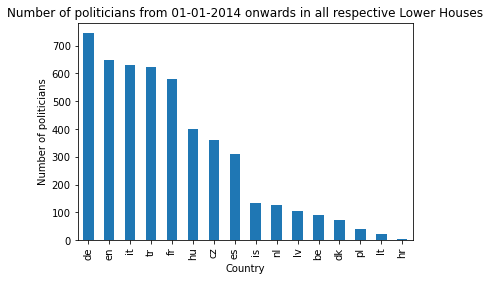

In [51]:
# Show the number of entities retrieved for all the countries.
number_of_politicians = {country: len(val) for country, val in politicians_gold_standard.items()}
pd.Series(number_of_politicians).sort_values(ascending=False).plot(kind='bar', title="Number of politicians from 01-01-2014 onwards in all respective Lower Houses",xlabel='Country',
                                     ylabel='Number of politicians')
plt.show()


In [352]:
def run_systems_for_country(gold_standard_country, systems=['DBPEDIA', 'WIKIDATA', 'YAGO'], limit=None, language='en', sleeptime=1.0):
    # Deze functie returned de predicties van de modellen
    # met limit kunnen we hele grote aantallen politici limiten (zoals Duitsland met 700) zodat we 
    # niet teveel queries maken. We kunnen dit leeg laten om het over alles te runnen.
    
    results = {}

    gold_standard_q_numbers = [item[1] for item in gold_standard_country][:limit]
    gold_standard_labels = [item[0] for item in gold_standard_country][:limit]

    for system in systems:

        sys_results = make_queries(gold_standard_labels, language, system, sleeptime=sleeptime)

        system_q_numbers = [item[1] if item else 'NIL' for item in sys_results]
        system_labels = [item[0] if item else 'NIL' for item in sys_results]
        
        results[system] = system_q_numbers

    return results

In [350]:
def calculate_country_accuracy(country_gold_standard, country_predictions_dict, eval_type='acc', limit=None):
    scores = {}
    
    gold_standard_q_numbers = [item[1] for item in country_gold_standard][:limit]
    
    for system, predictions in country_predictions_dict.items():
        scores[system] = accuracy(gold_standard_q_numbers, predictions) 
    
    return scores

In [1286]:
# single country test with a limit at 50, just to test the code
# YAGO uses cs for czech instead of cz
test_country = 'nl'
gold_standard_nl = politicians_gold_standard[test_country]
# remove duplicates
# gold_standard_nl  = list(set(hungarian_gold_standard))
    
# NOTE: we moeten hier indices van fouten opslaan, zo kunnen we zien welke mensen de systemen fout hebben, en kunnen we ook zien
# wie dat dan precies zijn.

nl_results = run_systems_for_country(gold_standard_nl, systems=['WIKIDATA'], limit=100, language=test_country, sleeptime=0.5)
system_mistakes = {}

for system in ['WIKIDATA']:
    mistakes = []
    for i, (a, b) in enumerate(zip(gold_standard_nl, nl_results[system])):
        if a[1] != b:
            print(a, b)
            mistakes.append(i)
    system_mistakes[system] = mistakes
            
print(system_mistakes)
# get the mistakes for all systems
venn_diagram_systems(system_mistakes)
calculate_country_accuracy(gold_standard_nl, nl_results, eval_type='acc', limit=100)
# first get the right data



100%|██████████| 100/100 [02:10<00:00,  1.31s/it]

('René Peters', 'Q29021764') Q43193445
('Sophie Hermans', 'Q28860996') Q74468310
{'WIKIDATA': [16, 30]}


KeyError: 'DBPEDIA'

<ipython-input-1301-65be646a4e04>:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "output" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('venn_diag_systems_raw.pdf', output='pdf')


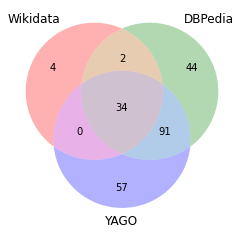

In [1301]:
venn3_unweighted(subsets = totalled_counts, set_labels = ('Wikidata', 'DBPedia', 'YAGO'), alpha = 0.3)
plt.savefig('venn_diag_systems_raw.pdf', output='pdf')
plt.show()

In [1096]:
# and a normalized one
normed_counts = (totalled_counts / totalled_counts.sum()).round(2)

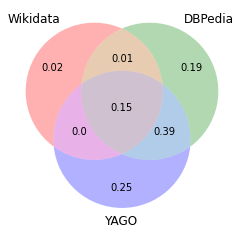

In [1097]:
venn3_unweighted(subsets = normed_counts, set_labels = ('Wikidata', 'DBPedia', 'YAGO'), alpha = 0.3)
plt.savefig('venn_diag_systems_normalized.png')
plt.show()

In [1050]:
# test the construction of a venn diagram
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

In [1016]:
# the creation of a venn diagram via this package is a bit tricky, as the different numbers are given in as a list where the order matters
# I have made a list with with each item means and what I want in there.

# 1. Only A
# 2. Only B
# 3. A and B
# 4. Only C
# 5. C and A 
# 6. C and B
# 7. A, B and C

# Translated to our case

# 1. Only Wikidata
# 2. Only DBpedia
# 3. Wikidata and DBPedia
# 4. Only YAGO
# 5. YAGO and WikiData
# 6. YAGO and DBPedia
# 7. ALL

    
    # return venn3(subsets = (a, b, c, d, e, f, g), set_labels = ('Wikidata', 'DBPedia', 'YAGO'), alpha = 0.5)
    
    #return venn3_unweighted(subsets = (a, b, c, d, e, f, g), set_labels = ('Wikidata', 'DBPedia', 'YAGO'), alpha = 0.3)
    
    

(1, 0, 0, 40, 0, 2, 1)


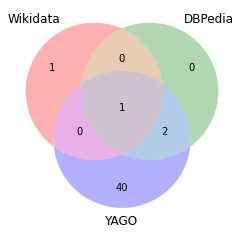

In [1017]:
v = venn_diagram_systems(system_mistakes)
#v.get_patch_by_id('111').set_color('grey')

In [ ]:
# Ik twijfel een beetje over welke versie ik moet nemen, die venn3 is natuurlijk meer 'waarheidsgetrouw' maar die unweighted maakt het wat 
# makkelijker

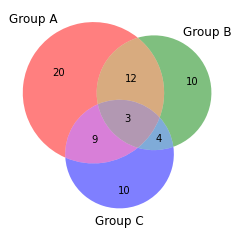

In [948]:
venn3(subsets = (20, 10, 12, 10, 9, 4, 3), set_labels = ('Group A', 'Group B', 'Group C'), alpha = 0.5);


Deze test ziet er goed uit, laten we het nu maar eens voor alle landen runnen!

In [ ]:
nl  0.16	0.98	0.92
de	0.52	0.97	0.74
fr	0.75	0.96	0.94
cz	0.15	0.00	0.00
hu	0.00	0.92	0.00
en	0.81	0.91	0.85
it	0.16	0.95	0.97
is	0.46	1.00	0.85
Mean	0.38	0.85	0.65
Tabel met voor 9 landen de accuracy 

In [31]:
# TODO: mark whether a certain country / language is supported in the systems.

complete_results = {}

label_limit = 100

for country, gold_standard_country in politicians_gold_standard.items():
    print("Currently processing the %s politicians" % country)
    country_results = run_systems_for_country(gold_standard_country, systems=['DBPEDIA','WIKIDATA', 'YAGO'], limit=label_limit, language=country,
                                             sleeptime=1.0)
    scores_country = calculate_country_accuracy(gold_standard_country, country_results, eval_type='acc', limit=label_limit)
    
    complete_results[country] = scores_country
    print(complete_results.keys())

  0%|          | 0/100 [00:00<?, ?it/s]

Currently processing the nl politicians


  0%|          | 0/100 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [118]:
# pd.DataFrame(complete_results).T.round(2)

In [144]:
results = {'nl': {'DBPEDIA': 0.37, 'WIKIDATA': 0.98, 'YAGO': 0.57},
 'pl': {'DBPEDIA': 0.16216216216216217,
  'WIKIDATA': 0.972972972972973,
  'YAGO': 0.918918918918919},
 'de': {'DBPEDIA': 0.52, 'WIKIDATA': 0.97, 'YAGO': 0.74},
 'fr': {'DBPEDIA': 0.75, 'WIKIDATA': 0.96, 'YAGO': 0.94},
 'cz': {'DBPEDIA': 0.15, 'WIKIDATA': 0.0, 'YAGO': 0.0},
 'hu': {'DBPEDIA': 0.0, 'WIKIDATA': 0.92, 'YAGO': 0.0},
'en': {'DBPEDIA': 0.81, 'WIKIDATA': 0.91, 'YAGO': 0.85},
'it': {'DBPEDIA': 0.16, 'WIKIDATA': 0.95, 'YAGO': 0.97},
'is': {'DBPEDIA': 0.46, 'WIKIDATA': 1.0, 'YAGO': 0.85}}

In [150]:
exp_2_results_df = pd.DataFrame(results).round(2).T
exp_2_results_df.loc['Mean', :] = exp_2_results_df.mean(axis=0)

In [151]:
exp_2_results_df.round(2)

,DBPEDIA,WIKIDATA,YAGO
nl,0.37,0.98,0.57
pl,0.16,0.97,0.92
de,0.52,0.97,0.74
fr,0.75,0.96,0.94
cz,0.15,0.00,0.00
hu,0.00,0.92,0.00
en,0.81,0.91,0.85
it,0.16,0.95,0.97
is,0.46,1.00,0.85
Mean,0.38,0.85,0.65


## Experiment 2: Lemmatization

In this experiment, we are going to look at lemmatization in ParlaMint. To do this, we try to find strings with lemma's that differ from the original string, meaning that lemmatization was performed. We then inspect the lemmatization for several countries to find out whether the lemmatization was correct or not.

In [81]:
org_ents = combined_df[(combined_df['lang'] == 'IS') & (combined_df['type'] == 'LOC')][['string', 'lemma']]

In [82]:
org_ents['string'] = org_ents['string'].str.lower()
org_ents['lemma'] = org_ents['lemma'].str.lower()

In [83]:
org_ents[org_ents['string'] != org_ents['lemma']].value_counts()

string              lemma            
íslandi             ísland               12651
íslands             ísland                6558
evrópu              evrópa                2653
noregi              noregur               1357
norðurlöndunum      norðurlönd             826
                                         ...  
norðurslóðum        norðurslóðir             1
norðurslóðasvæðinu  norðurslóðasvæðið        1
norðurslóðar        norðurslóð               1
norðurslóða         norðurslóð               1
a-hluta             a-hluti                  1
Length: 3521, dtype: int64

In [ ]:
person_df = combined_df[combined_df['type'] == 'PER']

In [804]:
# Check International Entities
international_entities = person_df.groupby('string')['lang'].nunique().sort_values(ascending=False)
entity_size = person_df.groupby('string')['lang'].size().sort_values(ascending=False)
largest_entities = international_entities[international_entities > 8]
largest_entities_and_popular = entity_size.loc[entity_size.index.isin(largest_entities.index)]
print(largest_entities_and_popular.index.tolist())

['Brexit', 'Trump', 'Macron', 'Salvini', 'Putin', 'Kennedy', 'Berlusconi', 'Erdogan', 'Emmanuel Macron', 'Merkel', 'David Cameron', 'Juncker', 'Donald Trump', 'Cameron', 'Obama', 'Boris Johnson', 'Tony Blair', 'David', 'John', 'Margaret Thatcher', 'Adam', 'Thomas', 'Theresa May', 'Michel Barnier', 'Hitler', 'Johnson', 'Donald Tusk', 'Churchill', 'Angela Merkel', 'Tusk', 'Maduro', 'Winston Churchill', 'Timmermans', 'Barnier', 'François Hollande', 'Ali', 'Hollande', 'Martin', 'Mogherini', 'Franco', 'Engels', 'Sarkozy', 'Orbán', 'Hyde', 'Thatcher', 'Charles Michel', 'Mussolini', 'Bush', 'Matteo Salvini', 'Shakespeare', 'Stalin', 'May', 'Nelson Mandela', 'Orban', 'Charlie', 'Einstein', 'Marx', 'Alex', 'Frans Timmermans', 'Anna', 'Keynes', 'Adam Smith', 'Greta Thunberg', 'Leonardo', 'Ursula von der Leyen', 'Federica Mogherini', 'John Kerry', 'Charles de Gaulle', 'Barack Obama', 'Mario Draghi', 'Jean-Claude Juncker', 'Roosevelt', 'Edward Snowden', 'Orwell', 'Hogan', 'Lavrov', 'Rousseau', 'La

In [901]:
famous_surnames = ['Trump',
                   'Macron',
                   'Putin',
                   'Erdogan',
                   'Merkel',
                   'Juncker',
                   'Cameron',
                   'Obama',
                   'Hitler', 
                   'Tusk']

famous_surnames_bulgarian = ['Тръмп',
                   "Макрон",
                   "Путин",
                   "Ердоган",
                   "Меркел",
                   "Юнкер",
                   "Камерън",
                   "Обама",
                   "Хитлер",
                   'бивк']
famous_surnames_latvian = []

We will use these entities to find them and any derivatives of their names in the afermentioned countries. We will then define 'canonical' for them, and count how often these occur, compared to the other variants

In [941]:
canonical_forms = {'PL': [['Trump', 'Donald Trump'], ['Emmanuel Macron', 'Macron'],
                         ['Putin', 'ładimir Putin'], ['Erdogan'], ['Angela Merkel', 'Angelą Merkel', 'Merkel'], ['Jean-Claude Juncker', 'Jean Juncker',
                                                                                                                'Juncker'],
                          ['David Cameron', 'Cameron'], ['Barack Obama' 'Obama'], ['Hitler-Stalin-Ribbentrop-Mołotow','Hitler', 'Adolf Hitler'],
                          ['Donald Tusk', 'Michał Tusk', 'Riposta Tuska', 'Berezę Kartuską']],
                  'CZ': [['Trump', 'Donald Trump'], ['Emmanuel Macron', 'Macron', 'Francie Macron'], ['Vladimír Putin', 'Putin'], ['Tayyip Erdogan',
                                                                                                                                  'Erdogan'],
                         ['Frau Merkel', 'Merkel', 'Angela Merkel'], ['Jean - Claude Juncker', 'Juncker'], ['Cameron Mc Kenna', 'Cameron', 'David Cameron'],
                         ['Obama', 'Barack Obama', 'Obamacare'], ['Hitler', 'Adolf Hitler'], ['Donald Tusk', 'Tusk']],
                  'BG': [['Тръмп', 'Доналд Тръмп'], ['Макрон', 'Емануел Макрон'], ['Путин', 'Владимир Путин'],
                         ["Ердоган", 'Таип Реджеп Ердоган', 'Реджеп Тайип Ердоган'], ['Меркел', 'Ангела Меркел'], ['Жан-Клод Юнкер', 'Жан Клод Юнкер', 'Юнкер'],
                         ['Дейвид Камерън', 'Камерън'], ['Обама', 'Барак Обама'], ["Хитлер", 'Адолф Хитлер'], []],
                   
                   'LV': [[], [], ['Putin', 'Putins'], ['Erdogans'], ['Angelas Merkeles'], [], [], ['Obamacare', 'Baraks Obama', 'Obamas'],
                                     ['Hitlers', 'Ādolfs Hitlers'], []], 'IS': [['Donald Trump', 'hr. Trump', 'Trump', 'Trumps'], ['Macron', 'Emmanuel Macron', 'Macrons'], [], ['Erdogan'],
                                                 ['Merkel', 'Angela Merkel', 'Merkels'], ['Juncker', 'Jean-Claude Juncker', 'Jean Claude Juncker'],
                                                 ['David Cameron', 'Cameron'], ['Obama', 'Michelle Obama', 'Barack Obama'],
                                                 ['Hitler', 'Adolf Hitler'], ['Tusk']],
                  'HR': [['Donald Trump Bush', 'Sokol-Trump', 'Trump', 'Bio Trump', 'Donald Trump'],
                         ['Macron', 'Merkel-Macron', 'Emmanuel Macron', 'Merkel Macron'],
                         ['Putin I', 'Putin'], ['Recep Tayyip Erdogan', 'Erdogan'], ['Angela Merkel', 'A. Merkel',
                                                                                    'Merkel-Macron', 'Merkel Macron'], ['Juncker',
                                                                                                                       'Jean Claude Juncker',
                                                                                                                       'Jan Cloud Juncker',
                                                                                                                       'Komisije Juncker',
                                                                                                                       'Jean-Claude Juncker'],
                         ['David Cameron', 'Cameron'], ['Obama', 'Barak Obama', 'Barack Obama'], ['Hitler'], ['Adolf Hitler']],
                   'NL': [['Trump', 'Donald Trump', 'POTUS Trump', 'Donald John Trump'], ['Emmanuel Macron', 'Macron'],
                         ['Poetin', 'Vladimir Poetin', 'Putin'], ['Erdogan', 'Recep Tayyip Erdogan'],
                          ['Merkel', 'Angela Merkel', 'Frau Merkel', 'Mutti Merkel'], ['Juncker', 'Jean-Claude Juncker', 'Claude Juncker',
                                                                                       'Jean Claude Juncker'],
                          ['David Cameron', 'Cameron'], ['Obama', 'Barack Obama', 'Michelle Obama', 'Barack Hussein Obama',
 'Sint Obama'], ['Hitler', 'Adolf Hitler'],
                          ['Donald Tusk', 'Donald Tusk', 'Elon Tusk']]}


In [852]:
# Nu gaan we voor al die entiteiten kijken hoe vaak ze worden gelemmatized.
def get_entities_with_lemma(entity, country):
    country_df = person_df[person_df['lang'] == country]
    relevant_rows = country_df[country_df['string'].str.lower().str.contains(entity.lower())]
    return relevant_rows

In [858]:
get_entities_with_lemma('Trump', 'PL')

,id,string,type,lang,size,file,date,entity_pos,lemma
962,seg235186.3.26,Donalda Trumpa,PER,PL,2,ParlaMint-PL_2017-04-07-sejm-39-3,2017-04-07 00:00:00,24166,Donald Trump
4309,seg665434.3.13,Trumpem,PER,PL,1,ParlaMint-PL_2017-07-18-senat-45-4,2017-07-18 00:00:00,37676,Trump
4704,seg665708.2.16,Trump,PER,PL,1,ParlaMint-PL_2017-07-18-senat-45-4,2017-07-18 00:00:00,51008,Trump
4824,seg665783.3.15,Trumpa,PER,PL,1,ParlaMint-PL_2017-07-18-senat-45-4,2017-07-18 00:00:00,56120,Trump
4983,seg665859.12.18,Trumpa,PER,PL,1,ParlaMint-PL_2017-07-18-senat-45-4,2017-07-18 00:00:00,59784,Trump
...,...,...,...,...,...,...,...,...,...
954485,seg208897.7.9,Donalda Trumpa,PER,PL,2,ParlaMint-PL_2017-02-09-sejm-35-2,2017-02-09 00:00:00,30004,Donald Trump
954509,seg208909.6.19,Donalda Trumpa,PER,PL,2,ParlaMint-PL_2017-02-09-sejm-35-2,2017-02-09 00:00:00,30444,Donald Trump
955730,seg209314.6.18,Donalda Trumpa,PER,PL,2,ParlaMint-PL_2017-02-09-sejm-35-2,2017-02-09 00:00:00,49623,Donald Trump
956283,seg209570.2.6,Trump,PER,PL,1,ParlaMint-PL_2017-02-09-sejm-35-2,2017-02-09 00:00:00,57218,Trump


In [944]:
# Turkey was left out of evaulation because of tagger problems
# LV might also be tricky.
from collections import defaultdict

type_of_word = 'lemma'

countries = defaultdict(int)
for country in tqdm(list(canonical_forms.keys())):
    fix_rates = []
    for i, item in enumerate(famous_surnames):
        entity_forms = get_entities_with_lemma('%s.*' % item, country)
        ranking = entity_forms[type_of_word].value_counts().to_dict()
        ranking = {key.lower(): val for key, val in ranking.items()}
        forms = canonical_forms[country][i]
        if sum(ranking.values()):
            num_canonical = sum([ranking.get(form.lower().strip(), 0) for form in forms]) / sum(ranking.values())
            fix_rates.append(num_canonical)
        else:
            pass
        
    countries[country] = np.array(fix_rates).mean()

# Do bg seperately



 29%|██▊       | 2/7 [00:07<00:19,  4.00s/it]<ipython-input-944-36f9cbf09add>:21: RuntimeWarning: Mean of empty slice.
  countries[country] = np.array(fix_rates).mean()
100%|██████████| 7/7 [00:25<00:00,  3.64s/it]


In [945]:
pd.Series(countries).sort_values()

LV    0.414224
PL    0.587702
HR    0.765910
CZ    0.800803
IS    0.801563
NL    0.935480
BG         NaN
dtype: float64

In [883]:
type_of_word = 'lemma'

countries = defaultdict(int)
for country in list(person_df['lang'].unique()):
    fix_rates = []
    for item in tqdm(famous_surnames):
        entity_forms = get_entities_with_lemma('%s.*' % item, country)
        ranking = entity_forms[type_of_word].value_counts()
        try:
            num_fixed = ranking[item] / ranking.values.sum()
        except:
            num_fixed = 0
        fix_rates.append(num_fixed)
    countries[country] = np.array(fix_rates).mean()

100%|██████████| 36/36 [00:10<00:00,  3.48it/s]


In [ ]:
# We can see that NL has the highest number, together with IT spanish and GB

In [884]:
pd.Series(countries).sort_values()

BG    0.000000
LT    0.023148
LV    0.039591
HU    0.112476
IS    0.210442
DK    0.240616
FR    0.350173
CZ    0.420965
TR    0.468135
PL    0.470569
BE    0.489864
SI    0.531261
HR    0.546398
GB    0.570864
ES    0.631473
IT    0.745406
NL    0.755018
dtype: float64

In [891]:
t = person_df['string'][person_df['lang'] == 'BG']
t[t.str.contains('Туск')].unique()

array(['Туск', 'Доналд Туск'], dtype=object)

The next step in this part is to see how this changes after lemmatization. This is relatively easy, we now use the lemmatized version of the words, and compare the ratio's

## How do we solve name aliasing?


We kunnen hier natuurlijk een vrij simpele aanpak volgen. Als we wikidata gebruiken kunnen we detecteren wanneer we een 'family' link te pakken hebben. Hier kunnen we dan alle subkandidaten pakken en deze ofwel reranken met context, of gewoon zoeken naar een politicus. (dat laatste is een beetje valsspelen, dus dat reranking lijkt mij het leukst en het meest 'generieke' idee)

We kunnen ook per entiteit kijken of we de 'rijkste' entiteit kunnen vinden, zodat we deze kunnen gebruiken in de entity linker.

In [132]:
# klein testje
entiteit = 'timmermans'
occurring_debates = combined_df[combined_df['lemma'].str.lower() == entiteit]['file'].unique()
for debate in occurring_debates[:50]:
    strings_in_file = combined_df[combined_df['file'] == debate]['lemma']
    selected_entities = list(strings_in_file[strings_in_file.str.lower().str.contains(entiteit)].unique())
    print(selected_entities)


['Timmermans']
['Timmermans']
['Timmermans']
['Timmermans', 'Fransa Timmermansa', 'Timmermansa']
['Timmermans']
['Timmermansa', 'Timmermans']
['Timmermans']
['Timmermansa', 'Fransa Timmermansa', 'komisja europejski Fransa Timmermansa', 'Timmermans', 'frans Timmermans']
['Timmermansem', 'komisja europejski Fransa Timmermansa', 'Timmermans', 'Timmermansa']
['Timmermans']
['Timmermans']
['Timmermans']
['Timmermansem', 'Timmermans']
['Timmermans']
['Frans Timmermans', 'Timmermans.De', 'Timmermans']
['Timmermans']
['Timmermans', 'Frans Timmermans']
['Timmermans']
['Timmermans']
['Timmermans', 'Mr Timmermans']
['Frans Timmermans', 'Timmermans']
['Frans Timmermans', 'Timmermans']
['Vice-President Timmermans', 'Timmermans']
['Timmermans']
['Timmermans']
['Timmermans']
['Timmermans']
['Timmermans']
['Timmermans', 'Frans Timmermans']
['Timmermans']
['Timmermans']
['Timmermans']
['Timmermans', 'commissaris Timmermans', 'Frans Timmermans', 'frans timmermans']
['Timmermans']
['Timmermans']
['Timmer

In [1148]:
person_df['string'] = person_df['string'].str.lower()
person_df['lemma'] = person_df['lemma'].str.lower()

<ipython-input-1148-5e3ee2afff51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_df['string'] = person_df['string'].str.lower()
<ipython-input-1148-5e3ee2afff51>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_df['lemma'] = person_df['lemma'].str.lower()


In [1282]:
# Let's first implement the aliasing technique
# current heuristic, look at the most often occuring of all the entities minus our short form
# or work in exact string match maybe?
# timespan is in weeks
from datetime import timedelta, datetime

def get_more_entity_forms(entity_form, timespan, country, exact_match=False):
    forms = []
    
    entity_form = entity_form.lower()
    occurring_entries = person_df[(person_df['lemma'].str.lower() == entity_form) & (person_df['lang'] == country)]
    occurring_debates = occurring_entries['file'].unique()
    occurring_dates = occurring_entries['date'].unique()
    
    if country == 'GB':
            occurring_dates = pd.to_datetime(occurring_entries['file'].str.slice(13, 23).unique())
    
    # For now I would say just pick one randomly
    if not len(occurring_dates):
        return entity_form
    
    start_debate = random.choice(occurring_debates)
    start_date = datetime.strptime(start_debate[13:23], '%Y-%m-%d')
    
    span_delta = timedelta(weeks=timespan)
    
    close_debates = [occurring_debates[i] for i, item in enumerate(occurring_dates) if ((start_date - span_delta) < item < (start_date + span_delta))]
    
    for debate in close_debates:
        strings_in_file = person_df[person_df['file'] == debate]['lemma']
        if exact_match:
            selected_entities = list(strings_in_file[strings_in_file.str.lower().str.contains('%s$' % entity_form, regex=True)])
        else:
            selected_entities = list(strings_in_file[strings_in_file.str.lower().str.contains(entity_form)])
        forms.extend(selected_entities)
    
    # now the algorithm comes into play, get the counts of these people

    forms_ranking = dict(Counter(forms).most_common())
    forms_ranking[entity_form] = 0
    best_other_entity = Counter(forms_ranking).most_common()[0][0]
    return best_other_entity





In [1263]:
# Timespan is in weeks
get_more_entity_forms('rutte', timespan=50, country='NL', exact_match=True)

KeyboardInterrupt: 

In [1315]:
# have to make sure our entities actually occur in the parlamint dataset
def get_suitable_aliases(list_of_aliases, country, num_ents=10):
    
    output = []
    
    possible_ents = pd.Series(person_df['string'][person_df['lang'] == country].unique())
    for i, item in enumerate(list_of_aliases):
        present = possible_ents.str.lower().str.strip().str.contains(item.lower().strip()).sum()
        if present:
            output.append(i)
    return output[:num_ents]
        

In [1353]:
# now we set up a bigger experiment for the aliasing
number_of_test_ents = 10
country_code = 'GB'
nl_test_orig_ents = [item[0] for item in politicians_gold_standard['en']]
nl_test_alias_ents = [" ".join(item.split()[1:]) for item in nl_test_orig_ents]
aliases_in_parlamint = get_suitable_aliases(nl_test_alias_ents, country_code, num_ents=number_of_test_ents)
nl_test_alias_ents = [nl_test_alias_ents[i] for i in aliases_in_parlamint]
nl_test_orig_ents = [nl_test_orig_ents[i] for i in aliases_in_parlamint]

one_week_resolved = [get_more_entity_forms(item, timespan=1, country=country_code, exact_match=True) for item in tqdm(nl_test_alias_ents)]
one_month_resolved = [get_more_entity_forms(item, timespan=4, country=country_code, exact_match=True) for item in tqdm(nl_test_alias_ents)]
three_month_resolved = [get_more_entity_forms(item, timespan=8, country=country_code, exact_match=True) for item in tqdm(nl_test_alias_ents)]
half_year_resolved = [get_more_entity_forms(item, timespan=26, country=country_code, exact_match=True) for item in tqdm(nl_test_alias_ents)]
year_resolved = [get_more_entity_forms(item, timespan=52, country=country_code, exact_match=True) for item in tqdm(nl_test_alias_ents)]
two_year_resolved = [get_more_entity_forms(item, timespan=104, country=country_code, exact_match=True) for item in tqdm(nl_test_alias_ents)]






  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:03<00:30,  3.36s/it]


 20%|██        | 2/10 [00:05<00:23,  2.92s/it]


 30%|███       | 3/10 [00:07<00:19,  2.71s/it]


 40%|████      | 4/10 [00:09<00:14,  2.38s/it]


 50%|█████     | 5/10 [00:10<00:10,  2.13s/it]


 60%|██████    | 6/10 [00:12<00:08,  2.03s/it]


 70%|███████   | 7/10 [00:13<00:05,  1.88s/it]


 80%|████████  | 8/10 [00:15<00:03,  1.77s/it]


 90%|█████████ | 9/10 [00:17<00:01,  1.76s/it]


100%|██████████| 10/10 [00:18<00:00,  1.89s/it]



  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:01<00:15,  1.69s/it]


 20%|██        | 2/10 [00:03<00:13,  1.73s/it]


 30%|███       | 3/10 [00:05<00:12,  1.72s/it]


 40%|████      | 4/10 [00:06<00:09,  1.65s/it]


 50%|█████     | 5/10 [00:08<00:08,  1.60s/it]


 60%|██████    | 6/10 [00:11<00:08,  2.12s/it]


 70%|███████   | 7/10 [00:13<00:06,  2.15s/it]


 80%|████████  | 8/10 [00:15<00:04,  2.12s/it]


 90%|█████████ | 9/10 [00:17<00

In [1354]:
for setting in [one_week_resolved, one_month_resolved, three_month_resolved, half_year_resolved, year_resolved, two_year_resolved]:
    score = 0
    for i in range(len(setting)):
        if nl_test_orig_ents[i].lower().strip() == setting[i].lower().replace('m. ', '').strip():
            score+=1
        else:
            print((nl_test_orig_ents[i].lower().strip(), setting[i].lower().strip()))
    print(score / number_of_test_ents)



('karen bradley', 'bradley')
('ben bradshaw', 'bradshaw')
('kevin brennan', 'brennan')
('andrew bridgen', 'bridgen')
('lyn brown', 'molton brown')
('greg clark', 'clark')
('edward timpson', 'timpson')
('rosie cooper', 'yvette cooper')
0.2
('karen bradley', 'bradley')
('ben bradshaw', 'bradshaw')
('john whittingdale', 'whittingdale')
('kevin brennan', 'brennan')
('andrew bridgen', 'bridgen')
('lyn brown', 'gordon brown')
('christopher chope', 'chope')
('edward timpson', 'james timpson')
('rosie cooper', 'cooper')
0.1
('karen bradley', 'bradley')
('ben bradshaw', 'bradshaw')
('john whittingdale', 'whittingdale')
('kevin brennan', 'brennan')
('lyn brown', 'lady brown')
('christopher chope', 'chope')
('greg clark', 'clark')
('rosie cooper', 'cooper')
0.2
('karen bradley', 'bradley')
('john whittingdale', 'whittingdale')
('andrew bridgen', 'bridgen')
('lyn brown', 'gordon brown')
('rosie cooper', 'cooper')
0.5
('karen bradley', 'denise bradley')
('ben bradshaw', 'john bradshaw')
('john whit

In [ ]:
# NL: [0, 0.1, 0.2, 0.1, 0.4, 0.5]
# FR: [0.4, 0.6, 0.5, 0.7, 0.7, 0.7]
# PL: [0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
# BE: [0.4, 0.5, 0.8, 0.9, 1.0, 1.0]
# GB: [0.2, 0.6, 0.3, 0.2, 0.5, 0.7]
# CZ: [0.6, 0.6, 0.8, 0.8, 0.8, 0.9]


<ipython-input-1361-fd0b77562786>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = ["0", "1 week", "1 month", "3 months", "6 months", "1 year", "2 years"])


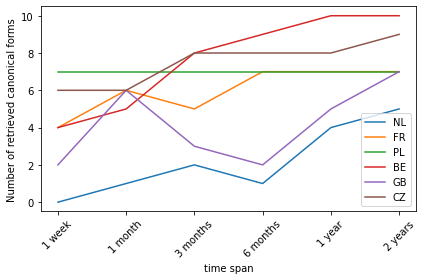

In [1361]:
aliasing_dict = pd.DataFrame({'NL': [0, 0.1, 0.2, 0.1, 0.4, 0.5], 'FR': [0.4, 0.6, 0.5, 0.7, 0.7, 0.7],
                'PL': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7], 'BE': [0.4, 0.5, 0.8, 0.9, 1.0, 1.0],
                'GB': [0.2, 0.6, 0.3, 0.2, 0.5, 0.7], 'CZ': [0.6, 0.6, 0.8, 0.8, 0.8, 0.9]})
aliasing_dict = aliasing_dict*10

ax = aliasing_dict.plot()
ax.set_xticklabels(labels = ["0", "1 week", "1 month", "3 months", "6 months", "1 year", "2 years"])
plt.xticks(rotation = 45)
plt.xlabel('time span')
plt.ylabel('Number of retrieved canonical forms')
plt.tight_layout()
plt.savefig('aliasing_algo_plot.png')
plt.show()

In [1254]:
import datetime
gb_dates = person_df[person_df['lang'] == 'GB']['file'].str.slice(13, 23)
person_df[person_df['lang'] == 'GB']['date'] = gb_dates

<ipython-input-1254-4762183ce0eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_df[person_df['lang'] == 'GB']['date'] = gb_dates


35         NaN
37         NaN
40         NaN
65         NaN
67         NaN
          ... 
2161539    NaN
2161544    NaN
2161552    NaN
2161576    NaN
2161577    NaN
Name: date, Length: 669817, dtype: object


In [1360]:
test_country = 'cz'
number_of_test_ents = 25
gold_standard_nl = [" ".join(item[0].split()[1:]) for item in random.sample(politicians_gold_standard[test_country], k=number_of_test_ents)]   

nl_results = run_systems_for_country(gold_standard_nl, systems=['DBPEDIA', 'WIKIDATA', 'YAGO'], limit=100, language='cs', sleeptime=0.5)

# for system in ['DBPEDIA', 'WIKIDATA', 'YAGO']:
#     mistakes = []
#     for i, (a, b) in enumerate(zip(gold_standard_nl, nl_results[system])):
#         if a[1] != b:
#             mistakes.append(i)
#     system_mistakes[system] = mistakes
            
# print(system_mistakes)
# # get the mistakes for all systems
# venn_diagram_systems(system_mistakes)
calculate_country_accuracy(gold_standard_nl, nl_results, eval_type='acc', limit=100)




  0%|          | 0/25 [00:00<?, ?it/s]


  4%|▍         | 1/25 [00:01<00:37,  1.58s/it]


  8%|▊         | 2/25 [00:03<00:36,  1.60s/it]


 12%|█▏        | 3/25 [00:05<00:38,  1.74s/it]


 16%|█▌        | 4/25 [00:07<00:40,  1.95s/it]


 20%|██        | 5/25 [00:09<00:39,  1.97s/it]


 24%|██▍       | 6/25 [00:11<00:38,  2.02s/it]


 28%|██▊       | 7/25 [00:13<00:36,  2.03s/it]


 32%|███▏      | 8/25 [00:15<00:33,  1.99s/it]


 36%|███▌      | 9/25 [00:17<00:29,  1.84s/it]


 40%|████      | 10/25 [00:19<00:28,  1.91s/it]


 44%|████▍     | 11/25 [00:21<00:27,  1.93s/it]


 48%|████▊     | 12/25 [00:23<00:25,  1.93s/it]


 52%|█████▏    | 13/25 [00:25<00:22,  1.90s/it]


 56%|█████▌    | 14/25 [00:27<00:21,  1.92s/it]


 60%|██████    | 15/25 [00:28<00:17,  1.78s/it]


 64%|██████▍   | 16/25 [00:29<00:14,  1.61s/it]


 68%|██████▊   | 17/25 [00:31<00:13,  1.68s/it]


 72%|███████▏  | 18/25 [00:33<00:12,  1.72s/it]


 76%|███████▌  | 19/25 [00:35<00:10,  1.76s/it]


 80%|████████  

{'DBPEDIA': 0.0, 'WIKIDATA': 0.0, 'YAGO': 0.0}

## Some Examples of Lemmatization

In [154]:
persons = combined_df[combined_df['type'] == 'PER']

In [166]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(persons[persons['string'].str.lower().str.contains('tusk')][['string', 'lang']].drop_duplicates())

                              string lang
81                 Donaldowi Tuskowi   PL
826                    Donalda Tuska   PL
852                            Tuska   PL
931                      Donald Tusk   PL
3435                    Donald Tuska   PL
3436                           Tusku   PL
3440                            Tusk   PL
21902               Donaldem Tuskiem   PL
51558                Donaldzie Tusku   PL
125738                       Tuskiem   PL
224585                 Michała Tuska   PL
224801                   Michał Tusk   PL
230769                       Tuskowi   PL
307565                    wice-Tuska   PL
311580                    Wina Tuska   PL
407409                         Tuski   PL
544581                 Riposta Tuska   PL
583357               Berezą Kartuską   PL
638325               Berezę Kartuską   PL
22681                           Tusk   ES
116030                   Donald Tusk   ES
224823                    señor Tusk   ES
84170                    Donald Tu

Below is a simple count of how often entities are lemmatized, by simple counting how many times the original string is equal to the lemmatization string (no lemmatization) and taking the inverse of that proportion.

In [187]:
persons[['string', 'lemma', 'lang']][persons['string'] == 'Donalda Tuska']

,string,lemma,lang
826,Donalda Tuska,Donald Tusk,PL
887,Donalda Tuska,Donald Tusk,PL
3548,Donalda Tuska,Donald Tusk,PL
3596,Donalda Tuska,Donald Tusk,PL
4479,Donalda Tuska,Donald Tusk,PL
...,...,...,...
488712,Donalda Tuska,Donald Tusk,HR
602699,Donalda Tuska,Donald Tusak,HR
201546,Donalda Tuska,Donaldo Tusek,CZ
311422,Donalda Tuska,Donaldo Tusek,CZ


In [4]:
lemmatization_percentage = combined_df.groupby(['lang', 'type']).apply(lambda x: (x['string'].str.lower() != x['lemma'].str.lower()).sum() / x.shape[0])

In [12]:
lemma_usage = lemmatization_percentage.unstack().sort_values(by='PER', ascending=False).round(2)

In [13]:
print(lemma_usage.to_latex())

\begin{tabular}{lrrrr}
\toprule
type &   LOC &  MISC &   ORG &   PER \\
lang &       &       &       &       \\
\midrule
LV   &   NaN &   NaN &  0.87 &  0.60 \\
TR   &  0.52 &   NaN &  0.72 &  0.45 \\
IS   &  0.67 &  0.80 &  0.64 &  0.41 \\
CZ   &  0.77 &  0.38 &  0.65 &  0.41 \\
PL   &  0.87 &   NaN &  0.76 &  0.36 \\
HR   &  0.62 &  0.91 &  0.69 &  0.36 \\
SI   &  0.76 &  0.91 &  0.75 &  0.34 \\
IT   &  0.06 &   NaN &  0.13 &  0.26 \\
FR   &  0.40 &  0.18 &  0.35 &  0.24 \\
BE   &  0.09 &  0.42 &  0.26 &  0.15 \\
HU   &   NaN &  0.26 &  0.18 &  0.15 \\
LT   &  0.24 &  0.50 &  0.88 &  0.05 \\
DK   &  0.12 &  0.61 &  0.41 &  0.04 \\
NL   &  0.04 &  0.41 &  0.10 &  0.03 \\
ES   &  0.01 &  0.08 &  0.04 &  0.02 \\
BG   &  0.09 &  0.73 &  0.68 &  0.01 \\
GB   &  0.00 &  0.06 &  0.01 &  0.00 \\
\bottomrule
\end{tabular}



In [214]:
# Tellingen maar nu uniek
# pak even de top 10 namen als proxy

lemmatization_percentage_unique = persons.groupby('lang').apply(lambda x: ( x[x['string'].str.lower() != x['lemma'].str.lower()]['string'].nunique() ) / x['string'].nunique())


In [216]:
lemmatization_percentage_unique.sort_values(ascending=False)

lang
TR    0.721067
LV    0.654971
CZ    0.596284
SI    0.552700
PL    0.523609
HR    0.521090
IS    0.504552
HU    0.320928
BE    0.174571
DK    0.169928
FR    0.114642
LT    0.094808
BG    0.082099
IT    0.050418
NL    0.046147
ES    0.032980
GB    0.009015
dtype: float64

# Extension 1: Matching Entities with Parliament Members

In this extension, we investigate how the usage of the metdata present in the parlamint corpus can help with the disambiguation / de-aliasing of names. For this we will use the XML files containing the parliament members for the various countries. We will then select semi-randomly several entities from the csv files with entities from 6 countries. We hand label them, and then perform the evaluation of the parliament member scoping approach.

In [86]:
# First we read in all metadata files and convert them to a 'python-friendly' format.
metadata_folders = [os.path.join('ParlaMintDatabases', file) for file in os.listdir('ParlaMintDatabases')]
import lxml.etree as ET
from collections import defaultdict
def read_xml_file(file_path):
    xml_file = ET.parse(file_path)
    namespaces = {'ns': 'http://www.tei-c.org/ns/1.0', 'xml': 'http://www.w3.org/XML/1998/namespace'}
    persons = xml_file.xpath('.//ns:person', namespaces=namespaces)
    persons_dict = defaultdict(dict)
    for person in persons:
        forename = person.xpath('.//ns:forename', namespaces=namespaces)
        surname = person.xpath('.//ns:surname', namespaces=namespaces)
        person_id = person.attrib['{http://www.w3.org/XML/1998/namespace}id']
        
        if forename:
            persons_dict[person_id]['forename'] = forename[0].text
        else:
            persons_dict[person_id]['forename'] = ''

        if surname:
            persons_dict[person_id]['surname'] = surname[0].text
        else:
            persons_dict[person_id]['surname'] = ''
            
    return persons_dict

In [87]:
# Now we construct the final dictionary, which contains all languages as key in the dict and the output of `read_xml_file` as the values.
all_parliament_members = {}
all_members = []
for parliament in metadata_folders:
    country = parliament[-6:-4]
    all_parliament_members[country] = read_xml_file(parliament)

In [69]:
nl_entities = combined_df[(combined_df.lang == 'NL') & (combined_df.type == 'PER')]['string'].unique()
gb_entities = combined_df[(combined_df.lang == 'GB') & (combined_df.type == 'PER')]['string'].unique()
pl_entities = combined_df[(combined_df.lang == 'PL') & (combined_df.type == 'PER')]['string'].unique()
cz_entities = combined_df[(combined_df.lang == 'CZ') & (combined_df.type == 'PER')]['string'].unique()
fr_entities = combined_df[(combined_df.lang == 'FR') & (combined_df.type == 'PER')]['string'].unique()
be_entities = combined_df[(combined_df.lang == 'BE') & (combined_df.type == 'PER')]['string'].unique()

In [70]:
sample_entities_nl = nl_entities[:20]
sample_entities_gb = gb_entities[:20]
sample_entities_pl = pl_entities[:20]
sample_entities_cz = cz_entities[:20]
sample_entities_fr = fr_entities[:40]
sample_entities_be = be_entities[:20]

In [71]:
print(sample_entities_nl)
print(sample_entities_gb)
print(sample_entities_pl)
print(sample_entities_cz)
print(sample_entities_fr)
print(sample_entities_be)

['De Vries' 'Oettinger' 'Roemer' 'Klein' 'Pechtold' 'Van Tongeren'
 'Schippers' 'Buma' 'Karabulut' 'Monasch' 'Van Helvert' 'De Rouwe' 'Knops'
 'Timmermans' 'Commissaris Timmermans' 'Juncker' 'Opstelten' 'Erdogan'
 'Mogherini' 'Segers']
['St George' 'Mr Speaker' 'Chester' 'Tim Draycott' 'Charlotte Leslie'
 'Jess' 'Halton' 'Graham Jones' 'Julie Cooper' 'Helen Jones'
 'Nicola Blackwood' 'John Pugh' 'Pauline Cafferkey' 'Frist' 'Hull'
 'Duncan Bew' 'Corby' 'Tom Pursglove' 'Mrs Bone' 'Harriet North']
['Piotra Łukasza Babiarza' 'Piotra Olszówkę' 'Piotr Olszówka'
 'Beatę Szydło' 'Grzegorza Schetyny' 'Grzegorza Schetynę' 'Rysiek'
 'Beata Szydło' 'Kaleta' 'Grzegorz Schetyna' 'Misiewiczów'
 'Donaldowi Tuskowi' 'Antoniemu Macierewiczowi' 'Kaczyński' 'Kaczyńskiego'
 'Jarosław Kaczyński' 'Szydło' 'Waszczykowskim' 'Macierewiczem'
 'Andrzejem Dudą']
['Jaroslava Faltýnka' 'Pavla Kováčika' 'Michala Kučeru' 'Petra Kudelu'
 'Pavel Kováčik' 'Jaroslav Faltýnek' 'Petr Kudela' 'Rámcová'
 'Robina Böhnische' 'R

We manually select 10 entities from each country, making sure that they are non ambigious, and that they are not noise in the dataset.

In [79]:
nl_entities = {'Oettinger': [], 'Roemer': [], 'Pechtold': [],
              'Van Tongeren': [], 'Schippers': [], 'Buma': [], 'Karabulut': [],
              'Monasch': [], 'Van Helvert': [], 'De Rouwe': []}

In [112]:
# gb_entities = {'Tim Draycott': [], 'Charlotte Leslie': [], 'Graham Jones': [], 'Julie Cooper': [],
#                'Helen Jones': [], 'Nicola Blackwood': [], 'John Pugh': [],
#                'Pauline Cafferkey': [], 'Duncan Bew': [], 'Tom Pursglove': []}
gb_entities = {'Draycott': [], 'Leslie': [], 'Jones': [], 'Cooper': [],
               'Jones': [], 'Blackwood': [], 'Pugh': [],
               'Cafferkey': [], 'Bew': [], 'Pursglove': []}


In [81]:
be_entities = {'Charles-Ferdinand Nothomb': [], 'Mark Eyskens': [],
               'Guy Verhofstadt': [], 'M. Bonnafé': [],
               'Gilkinet': [], 'Geens': [],
               'Van Biesen': [],  'M. Albert Frère': [], 'Tilmant': [],
               'Collega Temmerman': []}

In [82]:
fr_entities = {'Mme Gisèle Biémouret': [], 'Cessez': [],
 'M. Christian Jacob.': [], 'M. Nicolas Démoulin': [],
 'M. Paul Christophe': [], 'M. Paul-André Colombani': [],
 'M. Alexis Corbière': [], 'Buzyn': [], 'Idriss Déby': [],
              'M. Frédéric Barbier': []}

In [113]:
# Matching
# We do matching by cosine similarity matching between a name and all the members in the parliament.
def best_match_entity(entity_name, country):
    candidates = [item['surname'] for item in all_parliament_members[country].values()]
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
    vectorized_candidates = vectorizer.fit_transform(candidates)
    
    vectorized_entity = vectorizer.transform([entity_name])
    similarities = vectorized_entity @ vectorized_candidates.T
    
    best_match = candidates[similarities.argmax()]
    print("For %s, %s is the best match" % (entity_name, best_match))

In [114]:
for item in gb_entities.keys():
    best_match_entity(item, 'GB')

For Draycott, Boycott is the best match
For Leslie, Leslie is the best match
For Jones, Jones is the best match
For Cooper, Cooper is the best match
For Blackwood, Blackwood is the best match
For Pugh, Pugh is the best match
For Cafferkey, Sharkey is the best match
For Bew, Bew is the best match
For Pursglove, Pursglove is the best match


In [143]:
nl_local = get_entities_from_parlamint('international', country='CZ', exclude_types=['MISC', 'LOC', 'ORG'])

<ipython-input-44-ae4ab4ec3f94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popularity_df['lang_count'] = popularity_df['string'].map(popular_ents)


In [145]:
nl_local[:10]

,string,lang,lemma,lang_count
1653,Gabriel,CZ,Gabriel,9
1962,Adam,CZ,Adam,9
3761,Obama,CZ,Obama,12
5120,Reagan,CZ,Reagan,12
6394,David,CZ,David,11
6890,Putin,CZ,Putin,10
7832,James Bond,CZ,James Bond,10
10042,Robespierre,CZ,Robespierre,10
10121,Stalin,CZ,Stalin,9
10798,Bertolt Brecht,CZ,Bertolt Brecht,10


In [124]:

#all_parliament_members['FR']